# Asynchronous Dynamic Programming

## Dynamic Programming

Dynamic programming refers to the set of methods that iteratively approximate the Bellman Equations to estimate the values of states or state-action pairs. The Bellman Equations are equations that relate the value of future states to the value of the current state, or the value of future state-action pairs to the value of the current state-action pair. They are solvable in the ideal situation where we know the dynamics of the environment, namely the transition probabilities from one state to another given an action, the associated reward, and the expected next states. 

Mathematically, we want to estimate $v_\pi(s)$ which is the value at state $s$ given we follow a policy $\pi(a|s)$ which gives us the probability of selecting action $a$ given the agent is in state $s$.

To solve this, we first look at the the Bellman Equations, which gives us the relationship:

$v_\pi(s) = f(\pi(a|s), r, \gamma, \text{p}(s',r|s,a))$ which means $v_\pi$ is a function of:
* our policy $\pi(a|s)$
* immediate next reward $r$ 
* discount rate $\gamma$, where we discount future rewards by this factor between [0, 1]
* transition probabilities $\text{p}(s',r|s,a))$

Now, solving this directly becomes quite complicated especially with many states $s$, because effectively this becomes a system of $|S|$ unknowns $v_\pi(s)$ and equations where $|S|$ is the number of possible discrete states. Note that in this formulation, we assume that states, actions, and rewards are discrete.

A more practical method for estimating the value of $v_\pi(s)$ is Dynamic Programming. Which iteratively refines the estimates, following this rule:

$v_{k+1}(s) \leftarrow v_{k}(s)$

Which means we use the previous estimate $v_{k}(s)$ at iteration $k$ to compute a refined estimate $v_{k+1}(s)$. Now, in the limit as $k \rightarrow \inf$, we expect

$v_{k+1}(s) = v_{k}(s) = v_\pi(s)$

for some arbitrary policy $\pi(a|s)$

## Asynchronous Dynamic Programming

Now, the original formulation of dynamic programming requires that all states be updated in some sequence per iteration. Such that we update $v_{k+1}(s) \leftarrow v_{k}(s)$ for each $s \in S$. However, this becomes prohibitively expensive for cases where there are many possible states. In which case, we can apply a modified version called Asynchronous Dynamic Programming (ADP).

ADP allows flexibility to update the state values at any order. In fact, it's possible that certain states are updated much more frequently than others. It also allows us to update states as the agent "experiences" the environment. This is the formulation that we use in this experiment.

## The Experiment

We experiment on a simple gridworld problem. We create an $N \times N$ grid where there are $X$ cells that are the "goal states." The objective is for an agent randomly placed on the grid to get to any of these goal states as quickly as possible. 

Each transition from one state to another yields a -1 reward. If the agent bumps the border/edges of the grid, it stays in place but incurs a -1 reward. The reward in any of the goal states is 0. We use a discount rate of 0.99.

We experiment on three epsilon greedy policies: Greedy ($\epsilon$ = 0), Epsilon-Greedy ($\epsilon$ = 0.1), Random ($\epsilon$=1). Greedy always goes to the cell with the largest estimated value $v_k(s)$. If there are ties, it will pick randomly. Epsilon Greedy does the same thing except there's an $\epsilon$ chance it will pick randomly at each timestep. Random merely chooses any action with equal probability.

We wanted to see how these three policies explore the environment to estimate the state values $v_k(s)$ using dynamic programming.

If the agent reaches any of the goal, it resets into a random state excluding the goal states. However, its knowledge of the state values are kept, and so it can continue to refine the estimates.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

In [66]:
# generate gridworld with two terminal states
# padding to indivate border
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

class GridRL:
    def __init__(self, k=4, gamma=0.9, reward=-1, 
                 terminal_states=[(1, 1)], 
                 eps=None,
                 seed=None):
        np.random.seed(seed)
        self.k = k
        self.gamma = gamma
        self.reward = reward
        self.eps = eps
        self.terminal_states = terminal_states # terminal states
        self.v_pi = np.zeros(shape=(k, k)) # initial value estimates
        self.v_pi = np.pad(self.v_pi, 1, pad_with, padder=-1e3) # add padding
        self.init_state()

    def init_state(self):
        while True: # initialize states
            self.state = (np.random.choice(range(1, self.k+1)), np.random.choice(range(1, self.k+1)))
            if self.state not in self.terminal_states:
                break
        return None
    
    def random_action(self):
        conv = self.v_pi * self.filter # convolution of filter around state and v_pi
        next_states = np.argwhere(self.filter==1) # locations of max val
        next_state_idx = np.random.choice((next_states.shape[0]))
        next_state = next_states[next_state_idx, :]

        # only change if inside bounds
        if next_state[0] in range(1, self.k+1) and next_state[1] in range(1, self.k+1):
            self.prev_state = self.state
            self.state = next_state  
        else:
            self.prev_state = self.state      
                

    def greedy_action(self):
        conv = self.v_pi * self.filter # convolution of filter around state and v_pi
        max_local_val = max([conv[tuple(i)] for i in np.argwhere(self.filter==1)]) # max value around state
        next_states = np.argwhere(np.logical_and(conv == max_local_val, self.filter==1)) # locations of max val
        next_state_idx = np.random.choice((next_states.shape[0]))
        next_state = next_states[next_state_idx, :]
        
        self.prev_state = self.state
        self.state = next_state
    
    def gen_filter(self):
        # create filter around state
        self.filter = np.zeros(shape=(self.k+2, self.k+2)) # filter for convolution
        self.filter[(self.state[0]-1, self.state[1])] = 1
        self.filter[(self.state[0]+1, self.state[1])] = 1
        self.filter[(self.state[0], self.state[1]-1)] = 1
        self.filter[(self.state[0], self.state[1]+1)] = 1
        self.filter[(self.state[0], self.state[1])] = -999
        return None
    
    def update_v_pi(self):
        self.gen_filter() # generate filter based on current state
        # update state with surrounding state values
        vals = []
        for i in np.argwhere(self.filter==1):
            if tuple(i) in self.terminal_states:
                reward = 0
            else:
                reward = self.reward
            if i[0] in range(1, self.k+1) and i[1] in range(1, self.k+1): # make sure within bounds
                vals += [reward + self.gamma * self.v_pi[tuple(i)]]
            else:
                vals += [reward + self.gamma * self.v_pi[tuple(self.state)]] # stay current state
        vals = np.array(vals)
        self.v_pi[tuple(self.state)] = sum(vals)/4
    
    def step(self):
        self.update_v_pi()
        
        explore = np.random.choice([True, False], p=[self.eps, 1-self.eps])

        if explore:
            self.random_action()
        else:
            self.greedy_action()
                
        if tuple(self.state) in self.terminal_states:
            terminal = True
            reward = 0
            self.init_state() # reinitialize state
        else:
            terminal = False
            reward = self.reward

        return self.prev_state, self.state, reward, terminal

    def visualize(self, axs):
        # for visualization
        self.grid = np.zeros(shape=(self.k, self.k)) # grid
        self.grid = np.pad(self.grid, 1, pad_with, padder=-1e3) # add padding
        for t in self.terminal_states:
            self.grid[t] = 1
        self.grid[tuple(self.state)] = 0.5

        sns.heatmap(self.grid[1:-1, 1:-1], ax=axs[0], cmap='viridis', annot=False, cbar=False)
        sns.heatmap(self.v_pi[1:-1, 1:-1], ax=axs[1], cmap='RdBu', annot=False, cbar=False)
        
        plt.tight_layout()

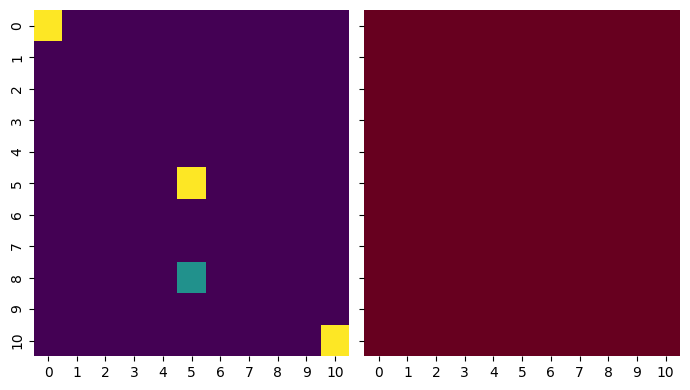

In [67]:
agent = GridRL(k=11, gamma=0.9, 
               terminal_states=[(1, 1), (6,6), (11, 11)], 
               eps=1,
               seed=None)

fig, axs = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
agent.visualize(axs)

In [68]:
def animate(iter):

    [ax.clear() for ax in axs]
    [ax.set_axis_off() for ax in axs]

    # Greedy
    eps = 0
    [agent1.step() for i in range(5)]
    agent1.visualize(axs[:2])
    axs[0].set_title(f"Epsilon = {eps}")

    # Eps-Greedy
    eps = 0.5
    [agent2.step() for i in range(5)]
    agent2.visualize(axs[2:4])
    axs[2].set_title(f"Epsilon = {eps}")


    # Random
    eps = 1
    [agent3.step() for i in range(5)]
    agent3.visualize(axs[4:])
    axs[4].set_title(f"Epsilon = {eps}")

    plt.tight_layout()

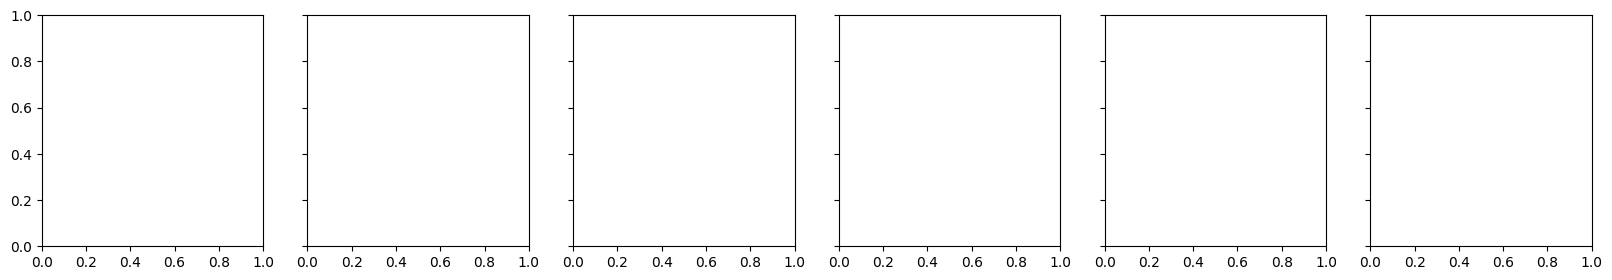

In [83]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3), sharey=True)
axs = axs.flatten()

k = 11
gamma = 0.99
terminal_states = [(1, 1)]

We visualize in the animation below the movement of the Greedy, Epsilon-Greedy, and Random agents, as well as the corresponding estimated state values $v_k(s)$. We find that random is slowest to estimate the state values, which is interesting because I initially thought random would be able to cover more of the grid because it is not encouraged to go to the goals.

The goal is indicated by the yellow cell. In terms of the value estimates, redder means more negative while bluer means less negative or more positive.

Note that each frame in the animation below corresponds to 5 timesteps in the simulation.

In [84]:
agent1 = GridRL(k=k, gamma=gamma, 
        terminal_states=terminal_states, 
        eps=0,
        seed=None)

agent2 = GridRL(k=k, gamma=gamma, 
        terminal_states=terminal_states, 
        eps=0.5,
        seed=None)

agent3 = GridRL(k=k, gamma=gamma, 
        terminal_states=terminal_states, 
        eps=1,
        seed=None)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=500, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

<Figure size 640x480 with 0 Axes>

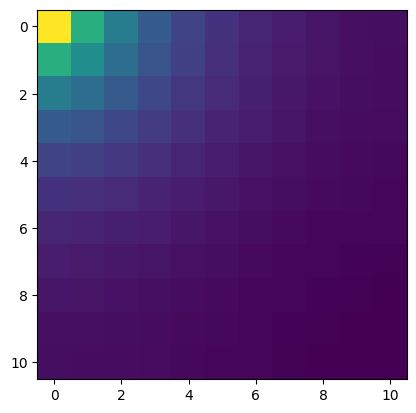

In [104]:
# what's the final value?

[agent1.step() for i in range(500000)]
plt.imshow(agent1.v_pi[1:-1, 1:-1])

v_pi_true = agent1.v_pi[1:-1, 1:-1]
# MSE over iterations, do it for X trials

We ran our Greedy agent for 500,000 timesteps to get our "ground truth" $v_\pi(s)$ estimate. Note that even if we use our random agent, it will still result in the same values, which we have validated. 

We then compare the rates at which our agents reach the ground truth values by computing the mean squared error between the estimate and the ground truth over many timesteps.

In [105]:
agent1 = GridRL(k=k, gamma=gamma, 
        terminal_states=terminal_states, 
        eps=0,
        seed=None)

agent2 = GridRL(k=k, gamma=gamma, 
        terminal_states=terminal_states, 
        eps=0.5,
        seed=None)

agent3 = GridRL(k=k, gamma=gamma, 
        terminal_states=terminal_states, 
        eps=1,
        seed=None)

mean1 = []
mean2 = []
mean3 = []
for i in range(100000):
        [agent1.step() for i in range(1)]
        [agent2.step() for i in range(1)]
        [agent3.step() for i in range(1)]

        mean1 += [np.mean((agent1.v_pi[1: -1, 1:-1].flatten() - v_pi_true.flatten())**2)]
        mean2 += [np.mean((agent2.v_pi[1: -1, 1:-1].flatten() - v_pi_true.flatten())**2)]
        mean3 += [np.mean((agent3.v_pi[1: -1, 1:-1].flatten() - v_pi_true.flatten())**2)]

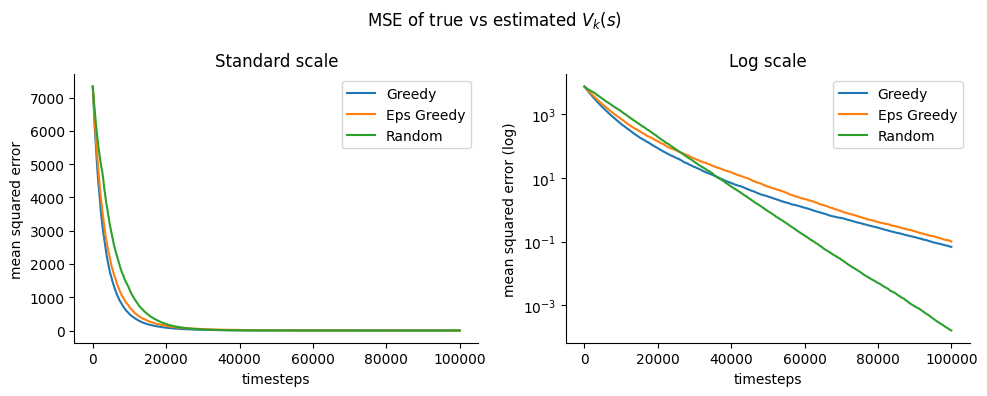

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mean1, label='Greedy')
axs[0].plot(mean2, label='Eps Greedy')
axs[0].plot(mean3, label='Random')
axs[0].legend()
axs[0].set_xlabel("timesteps")
axs[0].set_ylabel("mean squared error")
axs[0].set_title("Standard scale")

axs[1].plot(mean1, label='Greedy')
axs[1].plot(mean2, label='Eps Greedy')
axs[1].plot(mean3, label='Random')
axs[1].legend()
axs[1].set_xlabel("timesteps")
axs[1].set_ylabel("mean squared error (log)")
axs[1].semilogy()
axs[1].set_title("Log scale")

sns.despine()
plt.suptitle("MSE of true vs estimated $V_k(s)$")
plt.tight_layout()

We find that while Greedy leads to lower errors initially, there comes a time when Random leads to better estimates of $v_\pi(s)$ as indicated by lower MSE. We hypothesize that this is because Greedy and Epsilon-Greedy tend to get biased to move towards the goal, which reduces the chance of moving into certain areas, thus leading to lower opportunities to refine the estimates there. On the other hand, Random does not have this bias and thus we expect to continuously refine its estimates across the grid.